<a href="https://colab.research.google.com/github/129Ashish/Fashion_MNIST_Classification/blob/main/Fashion_MNIST_Cassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Hyperparameter Tuning the ANN using Optuna

# PLan of Action:
  # 1.Number of Hidden Layers
  # 2.Neurons per layer
  # 3.Number of epochs
  # 4.Optimizer
  # 5.Learning Rate
  # 6.Batch Size
  # 7.Dropout rate
  # 8.Weight decay(lambda)

# Imported Libraries :

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset , DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

#Data collection Libraries
import torchvision.datasets as datasets
import torchvision.transforms as transforms

# Check GPU availability


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Data Collection :

In [4]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [5]:
transform = transforms.ToTensor()

In [6]:
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

100%|██████████| 26.4M/26.4M [00:02<00:00, 12.0MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 202kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.77MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 10.7MB/s]


In [7]:
len(train_dataset)

60000

In [8]:
len(test_dataset)

10000

In [9]:
import tensorflow as tf
import torch

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Convert NumPy arrays to PyTorch tensors
X_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

print("Shape of x_train_tensor:", X_train_tensor.shape)
print("Shape of y_train_tensor:", y_train_tensor.shape)
print("Shape of x_test_tensor:", X_test_tensor.shape)
print("Shape of y_test_tensor:", y_test_tensor.shape)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Shape of x_train_tensor: torch.Size([60000, 28, 28])
Shape of y_train_tensor: torch.Size([60000])
Shape of x_test_tensor: torch.Size([10000, 28, 28])
Shape of y_test_tensor: torch.Size([10000])


# DATASET ANGLE

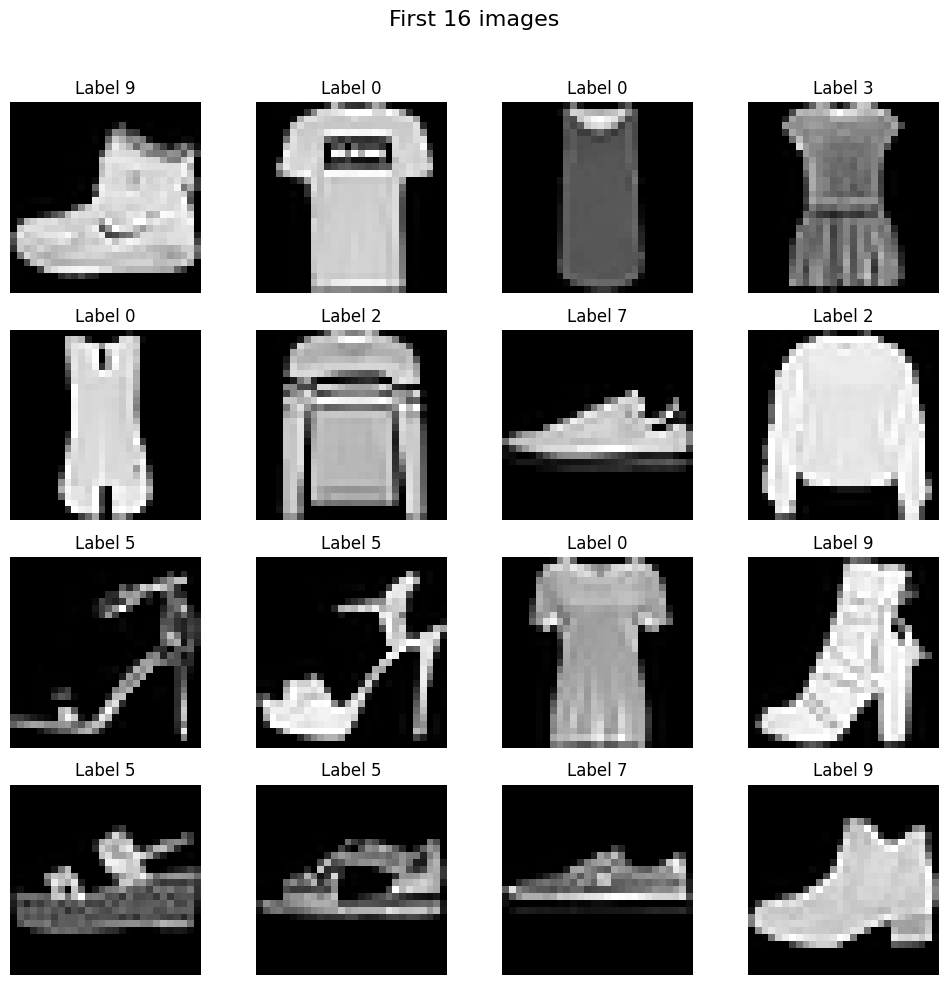

In [10]:
# create a 4x4 grid of images

fig, axes = plt.subplots(4,4,figsize=(10,10))
fig.suptitle("First 16 images",fontsize=16) # Corrected: changed subtitle to suptitle

#plot the first 16 images from the dataset
for i,ax in enumerate(axes.flat):
  # Access image and label using standard indexing for torchvision dataset
  img, label = train_dataset[i]
  # Convert the image tensor to a numpy array and remove the channel dimension
  img = img.squeeze().numpy()
  ax.imshow(img, cmap='gray') # Added cmap='gray' for grayscale images
  ax.axis('off')
  ax.set_title(f"Label {label}") # Corrected: accessing label from the dataset

plt.tight_layout(rect=[0,0,1,0.96])
plt.show()

# Dataset and DataLoader Classes :

In [11]:
from torch.utils.data import Dataset,DataLoader

class CustomDataset(Dataset):

  def __init__(self,features,labels):
    self.features=features
    self.labels=labels


  def __len__(self):
    return len(self.features)

  def __getitem__(self,idx):
    return self.features[idx],self.labels[idx]

In [12]:
train_dataset = CustomDataset(X_train_tensor,y_train_tensor)
test_dataset = CustomDataset(X_test_tensor,y_test_tensor)

# DATALOADER CLASS

In [13]:
train_loader = DataLoader(train_dataset,batch_size=32,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=32,shuffle=True)

print(f"length of train batch : {len(train_loader)}")
print(f"length of test batch : {len(test_loader)}")

length of train batch : 1875
length of test batch : 313


# DEFINING A MODEL

In [14]:
# defining class for model
class MyNN(nn.Module):

  def __init__(self,input_dim,output_dim,num_hidden_layer,neuron_per_layer,dropout_rate):
    super().__init__()
    #architecture of our neural network
    layer=[]#dynamic logic
    for i in range(num_hidden_layer):
      layer.append(nn.Linear(input_dim,neuron_per_layer))
      layer.append(nn.BatchNorm1d(neuron_per_layer))
      layer.append(nn.ReLU())
      layer.append(nn.Dropout(dropout_rate))
      input_dim =neuron_per_layer#input of second layer will be output of previous layer

    layer.append(nn.Linear(neuron_per_layer,output_dim))

    self.model=nn.Sequential(*layer) # *this symbol unpacks the list and make the layers individually accessed


  def forward(self,x):
    return self.model(x)

In [15]:
learning_rate=0.01
epochs = 100

# OBJECTIVE FUNCTION

In [16]:
# objective function

def objective(trial):

  #next hyperparameter values from the search space
  num_hidden_layer = trial.suggest_int('num_hidden_layer',1,5)# search space is from 1 to 5
  neuron_per_layer=trial.suggest_int('neuron_per_layer',8,128,step=8)#search space like 8-16-24-32..
  epochs=trial.suggest_int('epochs',10,50,step=10)
  learning_rate=trial.suggest_float('learning_rate',1e-5,1e-1,log=True)#logarithmically selection of learning_rate
  dropout_rate=trial.suggest_float('dropout_rate',0.1,0.5,step=0.1)
  #for implementing dropout we have to add new parameter in the MyNN class to use from here
  batch_size=trial.suggest_categorical('batch_size',[16,32,64,128])#select from these list items
  optimizer_name=trial.suggest_categorical('optimizer',['Adam','SGD','RMSprop'])#select from one of these  but we have to implement if-else statement for this.
  weight_decay=trial.suggest_float('weight_decay',1e-5,1e-3,log=True)#logarithmic selection

  #now the train_loader and test_loader will also be used inside the objective function because it can't be defined previously now.
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  test_loader =  DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

  #model init
  input_dim = 784
  output_dim = 10

  model = MyNN(input_dim,output_dim,num_hidden_layer,neuron_per_layer,dropout_rate)
  model.to(device)#directed to GPU

  #param init
  # learning_rate=0.01
  # epochs=50


  #optimizer selection
  criterion=nn.CrossEntropyLoss()

  if optimizer_name=='Adam':
    optimimzer=optim.Adam(model.parameters(),lr=learning_rate,weight_decay=weight_decay)
  elif optimizer_name=='SGD':
    optimimzer=optim.SGD(model.parameters(),lr=learning_rate,weight_decay=weight_decay)
  else :
    optimimzer=optim.RMSprop(model.parameters(),lr=learning_rate,weight_decay=weight_decay)

  #training loop
  total_epoch_loss = 0.0 # Initialize total_epoch_loss before the loop
  for epoch in range(epochs):
      for batch_features,batch_labels in train_loader:
            # Flatten the image data
            batch_features = batch_features.view(-1, 28 * 28).to(device) # Move data to device
            batch_labels = batch_labels.to(device) # Move labels to device

            #forward pass
            outputs=model(batch_features)
            #loss calculate
            loss=criterion(outputs,batch_labels)
            #gradient zero
            optimimzer.zero_grad() # Corrected optimizer name
            #back propogation
            loss.backward()
            #upgrade gradients
            optimimzer.step() # Corrected optimizer name

    #         total_epoch_loss += loss.item() # Accumulate loss

    # avg_loss=total_epoch_loss/len(train_loader) #avg epoch loss
    # print(f"epoch : {epoch+1}, Loss : {avg_loss}")

  #evaluation
  #set model to eval mode
  model.eval()
  # evaluation code for test data :
  total=0
  correct=0
  with torch.no_grad():
    for batch_features,batch_labels in test_loader:
      # Flatten the image data
      batch_features = batch_features.view(-1, 28 * 28).to(device) # Move data to device
      batch_labels = batch_labels.to(device) # Move labels to device

      outputs=model(batch_features)
      _,predicted=torch.max(outputs.data,1)
      total+=batch_labels.shape[0]
      correct+=(predicted==batch_labels).sum().item()
    accuracy=correct/total*100

  return accuracy

# CREATING STUDY USING OPTUNA

In [17]:
! pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 12.3 MB/s eta 0:00:00


In [18]:
import optuna

study = optuna.create_study(direction='maximize')

[I 2025-09-12 08:38:42,506] A new study created in memory with name: no-name-d8252f76-4759-4a66-b4c1-06b638cb2844


In [19]:
study.optimize(objective,n_trials=10)

[I 2025-09-12 08:40:59,131] Trial 0 finished with value: 94.69 and parameters: {'num_hidden_layer': 5, 'neuron_per_layer': 72, 'epochs': 20, 'learning_rate': 2.0433898926265255e-05, 'dropout_rate': 0.30000000000000004, 'batch_size': 32, 'optimizer': 'Adam', 'weight_decay': 0.0001058460528339316}. Best is trial 0 with value: 94.69.
[I 2025-09-12 08:44:59,136] Trial 1 finished with value: 96.55 and parameters: {'num_hidden_layer': 4, 'neuron_per_layer': 72, 'epochs': 40, 'learning_rate': 0.017608174956073537, 'dropout_rate': 0.2, 'batch_size': 32, 'optimizer': 'Adam', 'weight_decay': 1.3821342065197113e-05}. Best is trial 1 with value: 96.55.
[I 2025-09-12 08:50:58,737] Trial 2 finished with value: 97.59 and parameters: {'num_hidden_layer': 2, 'neuron_per_layer': 72, 'epochs': 50, 'learning_rate': 0.01120572482407961, 'dropout_rate': 0.30000000000000004, 'batch_size': 16, 'optimizer': 'SGD', 'weight_decay': 8.545805785355008e-05}. Best is trial 2 with value: 97.59.
[I 2025-09-12 08:56:38

In [20]:
print(study.best_value)
print(study.best_params)

97.71
{'num_hidden_layer': 2, 'neuron_per_layer': 128, 'epochs': 30, 'learning_rate': 0.00023717436805167206, 'dropout_rate': 0.5, 'batch_size': 64, 'optimizer': 'Adam', 'weight_decay': 2.586805024419036e-05}


# IMPLEMENTING MODEL

In [21]:
# Get the best parameters from the study
best_params = study.best_params

# Extract the best parameters for the model
num_hidden_layer = best_params['num_hidden_layer']
neuron_per_layer = best_params['neuron_per_layer']
dropout_rate = best_params['dropout_rate']

# Define input and output dimensions
input_dim = 784 # For flattened 28x28 MNIST images
output_dim = 10 # For 10 digits (0-9)

# Create the model with the best parameters
model = MyNN(input_dim, output_dim, num_hidden_layer, neuron_per_layer, dropout_rate)

# Move the model to the appropriate device (GPU if available)
model.to(device)

print("Model created with best hyperparameters:")
print(model)

Model created with best hyperparameters:
MyNN(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [22]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()

# Get optimizer from best parameters
optimizer_name = best_params['optimizer']
learning_rate = best_params['learning_rate']
weight_decay = best_params['weight_decay']

if optimizer_name == 'Adam':
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
elif optimizer_name == 'SGD':
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
else: # RMSprop
    optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Get the number of epochs and batch size from best parameters
epochs = best_params['epochs']
batch_size = best_params['batch_size']

# Re-create DataLoaders with the best batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# Training loop
print("Starting training...")
for epoch in range(epochs):
    model.train() # Set the model to training mode
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        # Flatten the input images
        inputs = inputs.view(inputs.size(0), -1)

        # Move inputs and labels to the device
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Print epoch loss
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader):.4f}")

print("Training finished.")

Starting training...
Epoch 1/30, Loss: 0.7937
Epoch 2/30, Loss: 0.3887
Epoch 3/30, Loss: 0.3216
Epoch 4/30, Loss: 0.2856
Epoch 5/30, Loss: 0.2622
Epoch 6/30, Loss: 0.2427
Epoch 7/30, Loss: 0.2347
Epoch 8/30, Loss: 0.2201
Epoch 9/30, Loss: 0.2114
Epoch 10/30, Loss: 0.2044
Epoch 11/30, Loss: 0.1914
Epoch 12/30, Loss: 0.1868
Epoch 13/30, Loss: 0.1835
Epoch 14/30, Loss: 0.1763
Epoch 15/30, Loss: 0.1737
Epoch 16/30, Loss: 0.1689
Epoch 17/30, Loss: 0.1651
Epoch 18/30, Loss: 0.1616
Epoch 19/30, Loss: 0.1592
Epoch 20/30, Loss: 0.1533
Epoch 21/30, Loss: 0.1517
Epoch 22/30, Loss: 0.1541
Epoch 23/30, Loss: 0.1479
Epoch 24/30, Loss: 0.1481
Epoch 25/30, Loss: 0.1450
Epoch 26/30, Loss: 0.1418
Epoch 27/30, Loss: 0.1420
Epoch 28/30, Loss: 0.1362
Epoch 29/30, Loss: 0.1375
Epoch 30/30, Loss: 0.1371
Training finished.


# EVALUATION

In [23]:
#evaluation
#set model to eval mode
model.eval()
# evaluation code for test data :
total=0
correct=0
with torch.no_grad():
  for batch_features,batch_labels in test_loader:
    # Flatten the image data
    batch_features = batch_features.view(batch_features.size(0), -1)
    #move data to gpu
    batch_features = batch_features.to(device)
    batch_labels = batch_labels.to(device)

    outputs=model(batch_features)
    _,predicted=torch.max(outputs.data,1)
    total+=batch_labels.shape[0]
    correct+=(predicted==batch_labels).sum().item()
  accuracy=correct/total*100

print(f"Accuracy on test set: {accuracy:.2f}%")

Accuracy on test set: 97.83%


In [24]:
#evaluation
#set model to eval mode
model.eval()
# evaluation code for train data :
total=0
correct=0
with torch.no_grad():
  for batch_features,batch_labels in train_loader:
    # Flatten the image data
    batch_features = batch_features.view(batch_features.size(0), -1)
    #move data to gpu
    batch_features = batch_features.to(device)
    batch_labels = batch_labels.to(device)

    outputs=model(batch_features)
    _,predicted=torch.max(outputs.data,1)
    total+=batch_labels.shape[0]
    correct+=(predicted==batch_labels).sum().item()
  accuracy=correct/total*100

print(f"Accuracy on train set: {accuracy:.2f}%")

Accuracy on train set: 98.92%


# VISUALIZING CNN MODEL

In [25]:
!pip install torchviz

import torchviz
import torch


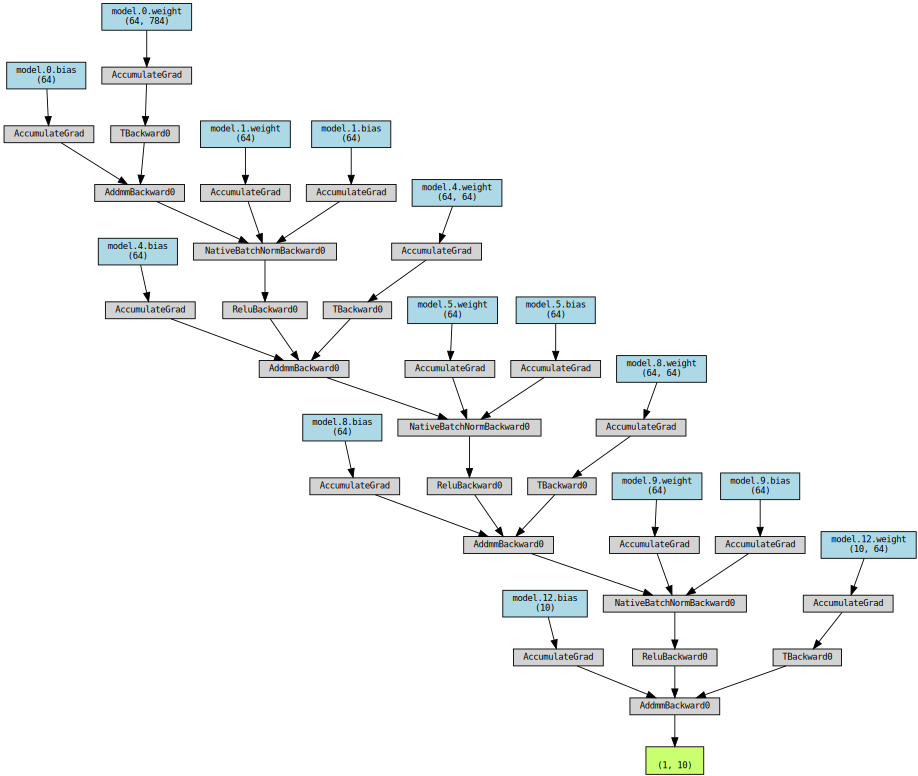

In [26]:
# Assuming 'model' is your MyNN instance
# Create a dummy input tensor with the expected shape (batch_size, num_features)
dummy_input = torch.randn(1, 784) # Assuming num_features is 784 for FashionMNIST

# Create a sample model instance with example parameters for visualization
# You can replace these with parameters from the best trial if you want to visualize the best model
sample_model = MyNN(input_dim=784, output_dim=10, num_hidden_layer=3, neuron_per_layer=64, dropout_rate=0.3) # Added dropout_rate

# Set the model to evaluation mode before visualizing
sample_model.eval()

# Generate the graph visualization
dot = torchviz.make_dot(sample_model(dummy_input), params=dict(sample_model.named_parameters()))

# Set the model back to training mode if needed
sample_model.train()

# To display the graph in Colab, you can use the display function
display(dot)